## 1. Data Treating

#### 1.0 Enviroment Set-up

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns



# matplotlib set up
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

#### 1.1 Data Loading

In [2]:
csv_path = "Data/SPY_2020-07-01_2021-07-01_minute.csv"
df = pd.read_csv(csv_path)

data_raw = df.copy()
data_raw = data_raw.set_index('timestamp')
# data_raw = data_raw.head(10000).set_index('timestamp')

In [3]:
data_raw.head(5)

,open,high,low,close,volume,dollar_volume,tick_count,trade_size_mean,trade_size_std,zero_return_count,price_direction_ratio,large_trade_count,large_trade_volume,vwap,large_trade_ratio,large_trade_volume_ratio
timestamp,,,,,,,,,,,,,,,,
2020-07-01 04:00:00-04:00,308.68,308.84,308.68,308.83,656.0,202545.01,16,41.000000,42.842347,9,0.250000,0,0.0,308.757637,0.0,0.0
2020-07-01 04:01:00-04:00,308.78,308.79,308.74,308.74,2594.0,800940.16,9,288.222222,219.928271,4,0.222222,0,0.0,308.766446,0.0,0.0
2020-07-01 04:02:00-04:00,308.77,308.84,308.77,308.84,807.0,249212.90,4,201.750000,235.213910,2,0.500000,0,0.0,308.814002,0.0,0.0
2020-07-01 04:03:00-04:00,308.82,308.84,308.82,308.84,89.0,27485.78,3,29.666667,9.073772,2,0.333333,0,0.0,308.828989,0.0,0.0
2020-07-01 04:04:00-04:00,308.84,308.90,308.84,308.90,501.0,154738.60,5,100.200000,86.024415,2,0.600000,0,0.0,308.859481,0.0,0.0


#### 1.2 Labels

In [4]:
# ---------- Labels & Forward Log Returns  ----------

H   = 5        # 5 bar lookahead
TAU = 0.01     # 1% threshold

# Log Returns：ln(P_{t+H} / P_t)
fwd_ret_full = np.log(data_raw['close'].shift(-H) / data_raw['close'])

labels = np.select(
    [fwd_ret_full >  TAU,
     fwd_ret_full < -TAU],
    [ 1,              -1],        # Buy=1, Sell=-1
    default = 0
)

labels = pd.Series(labels, index=fwd_ret_full.index)\
           .where(fwd_ret_full.notna())

data_raw['action'] = labels
data_raw = data_raw.dropna(subset=['action'])

In [5]:
data_raw[data_raw['action'] != 0].size

2074

#### 1.3 Features Selection

In [6]:
from ta.momentum import RSIIndicator

# Define columns for Min-Max normalization
unbounded_features_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'vwap', 'dollar_volume',
    'tick_count', 'trade_size_mean',
    'zero_return_count', 'large_trade_count',
    'large_trade_volume'
]

# features selecting function
def compute_bounded_indicators(
    df: pd.DataFrame,
    unbounded_cols: list[str],
    rsi_period: int = 14
) -> pd.DataFrame:
    """
    For each column in the specified list "unbounded_cols" in df, compute the RSI as a bounded indicator
    and append it as a new column. Automatically drop all initial rows with NaN values due to RSI's rolling
    window computation, and fill any remaining NaNs using linear interpolation.

    Parameters
    ----------
    df : pd.DataFrame
        The original DataFrame, which should contain at least the columns listed in unbounded_cols.
        These columns are assumed to have no missing values initially.
    unbounded_cols : List[str]
        A list of column names for which RSI (bounded indicator) will be computed, e.g.:
        ['open', 'high', 'low', 'close', 'volume', 'vwap', 'dollar_volume',
         'tick_count', 'trade_size_mean', 'zero_return_count',
         'large_trade_count', 'large_trade_volume']
    rsi_period : int, default 14
        The window size for RSI computation. The RSI output range is [0, 100].

    Returns
    ----------
    df_out : pd.DataFrame
        The resulting DataFrame containing all original columns plus RSI columns
        (named "rsi(col)") for each column in unbounded_cols. All leading rows with NaN values
        are dropped, and remaining scattered NaNs are linearly interpolated.
    """

    data = df.copy()

    # 1. Compute RSI for each specified unbounded column
    for col in unbounded_cols:
        # RSIIndicator expects a pd.Series as input
        rsi_obj = RSIIndicator(close=data[col], window=rsi_period)
        data[f"rsi({col})"] = rsi_obj.rsi()

    # 2. Find the first row without any NaN and drop all rows before it
    mask_any_na = data.isna().any(axis=1)
    if mask_any_na.all():
        # If all rows contain NaNs (edge case), return an empty DataFrame with same columns
        return data.iloc[0:0]

    first_valid_idx = mask_any_na.idxmin()  # First False (i.e., no NaN) row index
    data = data.loc[first_valid_idx:].copy()

    # 3. Apply linear interpolation to fill remaining scattered NaNs
    data = data.interpolate(method="linear", limit_direction="forward", axis=0)

    # (Optional) If there are still NaNs at the tail, may choose to backfill:
    # data = data.fillna(method="bfill")

    return data

data_featured = compute_bounded_indicators(data_raw, unbounded_cols=unbounded_features_cols)
data_featured = data_featured.drop(columns=unbounded_features_cols)

In [7]:
data_featured.sample(5)

,trade_size_std,price_direction_ratio,large_trade_ratio,large_trade_volume_ratio,action,rsi(open),rsi(high),rsi(low),rsi(close),rsi(volume),rsi(vwap),rsi(dollar_volume),rsi(tick_count),rsi(trade_size_mean),rsi(zero_return_count),rsi(large_trade_count),rsi(large_trade_volume)
timestamp,,,,,,,,,,,,,,,,,
2020-08-24 08:47:00-04:00,95.101916,0.181818,0.090909,0.294974,0.0,55.240005,55.494886,55.264683,55.694507,48.259975,53.532624,48.259941,49.231908,48.452867,49.722058,52.832482,48.718354
2021-01-28 08:03:00-05:00,222.251870,0.233645,0.018692,0.106508,0.0,36.649573,58.249023,46.145253,39.355907,53.794217,36.293283,53.783942,54.906711,50.278059,59.565778,51.036013,50.616575
2020-12-23 10:00:00-05:00,225.605733,0.224120,0.016009,0.138637,0.0,57.119838,58.559349,53.597003,55.706080,48.775903,53.692113,48.780186,49.202940,48.973491,48.110944,48.966657,47.929001
2021-01-14 09:08:00-05:00,136.993885,0.269231,0.038462,0.296883,0.0,47.052967,47.697482,50.699293,51.211172,47.446875,47.074849,47.446861,49.232034,47.238927,48.423731,48.147434,47.582771
2021-01-04 19:51:00-05:00,115.423423,0.333333,0.000000,0.000000,0.0,59.057957,63.536558,64.389596,59.299114,45.735218,60.152852,45.734274,45.165872,47.362875,44.416897,44.605685,47.091218


In [8]:
# seperate action_labels for creating y
action_labels = data_featured["action"].values

In [9]:
action_labels

array([0., 0., 0., ..., 0., 0., 0.])

#### 1.4 Standardization + PCA

In [10]:
# Standardize features to zero mean and unit variance
scaler = StandardScaler()
data_std  = scaler.fit_transform(data_featured)

# Let PCA determine how many principal components are needed to explain ≥90% of the variance
pca_full = PCA().fit(data_std)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)   # Cumulative explained variance
n_pc     = np.argmax(cum_var >= 0.90) + 1    # First index where cumulative variance ≥ 90%

print(f"{n_pc} principal components are sufficient to explain ≥90% of the variance")

pca = PCA(n_components=n_pc, random_state=42)
data_pca = pca.fit_transform(data_std)

7 principal components are sufficient to explain ≥90% of the variance


In [11]:
data_pca.shape

(220143, 7)

#### 1.5 Discovering Data Patterns

In [12]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from Utility import kmean_job

import os


scores = {}
futures = []

with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    for k in range(2, 6):
        fut = executor.submit(kmean_job, k, data_pca)
        futures.append(fut)

    for fut in tqdm(as_completed(futures), total=len(futures), desc="Computing silhouette_score for each k"):
        k_val, score_val = fut.result()
        scores[k_val] = score_val

best_k = max(scores, key=scores.get)
print("Best k (silhouette max) = ", best_k)
print("Scores for each k:", scores)


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(data_pca)


Computing silhouette_score for each k: 100%|██████████| 4/4 [07:32<00:00, 113.00s/it]


Best k (silhouette max) =  2
Scores for each k: {5: np.float64(0.2075250552328456), 4: np.float64(0.19972617465813414), 3: np.float64(0.23677801517498892), 2: np.float64(0.24804548612567057)}


In [13]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(data_pca)

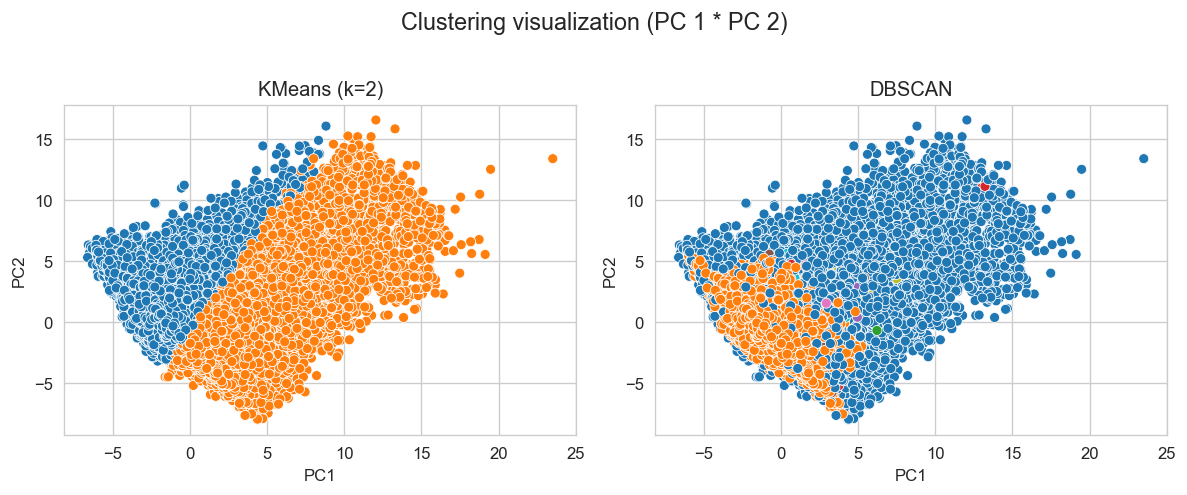

In [14]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# KMeans
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_km.astype(str),
    palette="tab10", ax=axes[0], legend=False
)
axes[0].set_title(f"KMeans (k={best_k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# DBSCAN
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_db.astype(str),
    palette="tab10", ax=axes[1], legend=False
)
axes[1].set_title("DBSCAN")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.suptitle("Clustering visualization (PC 1 * PC 2)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [12]:
feature_array = data_pca.copy()
target_array = action_labels.copy()
feature_array.shape, target_array.shape

((220143, 7), (220143,))

#### 1.6 Creating X，y data

In [13]:
seq_len = 16

n_samples = len(action_labels) - seq_len

X = []
y = []

# Populate X and y using a sliding window
for i in range(n_samples):
    # X[i] = features_array[i : i+seq_len]
    X.append(feature_array[i : i + seq_len, :])
    # y[i] = target_array[i+seq_len]
    y.append(target_array[i + seq_len])

X = np.array(X); y = np.array(y)


In [14]:
X.shape, y.shape

((220127, 16, 7), (220127,))

In [15]:
train_pct = 0.7
valid_pct = 0.15
test_pct = 0.15

total_len = X.shape[0]

train_len = int(train_pct * total_len)
valid_len = int(valid_pct * total_len)
test_len = int(test_pct * total_len)

X_train = X[:train_len]
X_valid = X[train_len:train_len+valid_len]
X_test = X[train_len+valid_len:]

y_train = y[:train_len]
y_valid = y[train_len:train_len+valid_len]
y_test = y[train_len+valid_len:]


print("X shape:", X_train.shape, X_valid.shape, X_test.shape)
print("y shape:", y_train.shape, y_valid.shape, y_test.shape)


X shape: (154088, 16, 7) (33019, 16, 7) (33020, 16, 7)
y shape: (154088,) (33019,) (33020,)


In [16]:
# Flatting Data
# Assume X_train.shape == (154088, 16, 7) and y_train.shape == (154088,)
# Reshape X_train from (n_samples, seq_len, n_feats) to (n_samples, seq_len * n_feats)
n_samples, seq_len, n_feats = X_train.shape

X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
X_valid_flat = X_valid.reshape(X_valid.shape[0], seq_len * n_feats)
X_test_flat  = X_test.reshape(X_test.shape[0],  seq_len * n_feats)

In [17]:
# Shape check
print(X_train.shape)         # (154088, 16, 7)
X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
print(X_train.shape)         # still (154088, 16, 7)
print(X_train_flat.shape)    # (154088, 112)

(154088, 16, 7)
(154088, 16, 7)
(154088, 112)


## 2. Model Building

#### 2.0. Classifier Set-up

In [20]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.linear_model   import LogisticRegression, RidgeClassifier
from sklearn.svm            import SVC
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, f1_score,
                             classification_report, confusion_matrix)

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [47]:
# preparation for back-test

idx_all   = data_featured.index[seq_len:]  

idx_all   = data_featured.index[seq_len:]               # timeline after windowing
idx_test  = idx_all[len(y_train)+len(y_valid):]         # align with y_test

#### 2.1 Model Selection - Hyperparameter Tuning

In [21]:
# Model zoo (6 total)

sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs'),

    "Ridge":     RidgeClassifier(alpha=0.5),

    "k-NN":    KNeighborsClassifier(n_neighbors=15, weights='distance'),

    "Random Forest":  RandomForestClassifier(
        n_estimators=400, min_samples_leaf=25,
        n_jobs=-1, random_state=42),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.05, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-4, random_state=42)
}


In [22]:
# Parameter Grids
param_grids = {
    "LogReg-Softmax": {
        "C": [0.01, 0.1, 1.0], 
        "solver": ["lbfgs"], 
        "penalty": ["l2"]
        # Can add more parameters here, such as class_weight, if needed
    },

    "Ridge": {
        "alpha": [0.1, 0.4, 0.7, 1.0],
    },

    "k-NN": {
        "n_neighbors": [5, 10, 15],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # p=1 (Manhattan distance), p=2 (Euclidean distance)
    },

    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [4, 6],
        "min_samples_leaf": [1, 5, 10],
        "max_features": ["sqrt", "log2"]
    },

    "Hist GBDT": {
        "max_depth": [4, 6],
        "learning_rate": [0.01, 0.1],
        "max_iter": [200, 600],
        # class_weight is already set to 'balanced' during initialization; you can tune it here if needed
    },
    
    "2-Layer MLP": {
        "hidden_layer_sizes": [(128, 64), (256, 128)],
        "activation": ["relu", "tanh"],
        "alpha": [1e-5, 1e-3],
        "learning_rate_init": [1e-4]
    }
}

In [30]:
# Use a smaller size data to test parameters
X_train_flat_demo = X_train_flat[:10000]
y_train_demo = y_train[:10000]

In [62]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Set cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model and perform GridSearchCV
best_estimators = {}  # Store the best estimator for each model
best_params = {}      # Store the best parameters for each model
best_scores = {}      # Store the best cross-validation score for each model

for name, model in sk_models.items():
    print(f"\n>> Tuning {name} ...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="accuracy",   # can change this to other metrics like 'roc_auc_ovr', 'f1_macro', etc.
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_flat_demo, y_train_demo)
    best_estimators[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    best_scores[name] = grid.best_score_
    print(f"  - Best score: {grid.best_score_:.4f}")
    print(f"  - Best params: {grid.best_params_}")

# Print tuning summary for all models
print("\n\n=== Summary of Best Models ===")
for name in sk_models.keys():
    print(f"{name}:")
    print(f"    Best CV score : {best_scores[name]:.4f}")
    print(f"    Best params   : {best_params[name]}")
    print("-----------------------------------------------")


>> Tuning LogReg-Softmax ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mul

  - Best score: 0.9979
  - Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

>> Tuning Ridge ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  - Best score: 0.9995
  - Best params: {'alpha': 0.1}

>> Tuning k-NN ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9991
  - Best params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

>> Tuning Random Forest ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9989
  - Best params: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

>> Tuning Hist GBDT ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9989
  - Best params: {'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 600}

>> Tuning 2-Layer MLP ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ................n_neighbors=5, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=5, p=2, weights=distance; total time=   0.1s
[CV] END ...............n_neighbors=10, p=1, weights=uniform; total time=   0.9s
[CV] END ...............n_neighbors=15, p=1, weights=uniform; total time=   0.9s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   4.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=10, n_estimators=200; total time=   3.6s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=10, n_estimators=400; total time=   6.6s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=10, n_estimators=400; total time=   5.0s
[CV] END max_depth=6, max_features=sqr

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..........................................alpha=0.4; total time=   0.0s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   1.0s
[CV] END ..............n_neighbors=10, p=1, weights=distance; total time=   0.9s
[CV] END ..............n_neighbors=15, p=2, weights=distance; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   3.9s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=10, n_estimators=200; total time=   3.8s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, n_estimators=200; total time=   2.7s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=400; total time=   5.0s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=200; total time=   4.5s
[CV] E

In [63]:
# Finalized Model Zoo
sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs', penalty='l2'),

    "Ridge":     RidgeClassifier(alpha=0.1),

    "k-NN":           KNeighborsClassifier(n_neighbors=5, p=2, weights='distance', n_jobs=-1),

    "Random Forest":  RandomForestClassifier(
        n_estimators=200, min_samples_leaf=1,
        n_jobs=-1, random_state=42, max_depth=4, max_features='sqrt',),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.01, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-5, random_state=42, learning_rate_init=1e-4)
}


#### 2.2 Model Evaluation: Fit, Predict, and Collect Metrics

In [64]:
metric_rows, cmaps = [], {}
for name, clf in sk_models.items():
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_valid_flat)

    acc = accuracy_score(y_valid, y_pred)
    f1  = f1_score(y_valid, y_pred, average='macro')
    metric_rows.append({"model": name, "accuracy": acc, "macro_F1": f1})

    cmaps[name] = confusion_matrix(y_valid, y_pred,
                                   labels=[-1, 0, 1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_valid, y_pred, digits=3))

metric_df = pd.DataFrame(metric_rows).set_index("model").round(3)
display(metric_df)

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg-Softmax
              precision    recall  f1-score   support

        -1.0      0.000     0.250     0.001         4
         0.0      1.000     0.890     0.942     33011
         1.0      0.002     0.750     0.004         4

    accuracy                          0.890     33019
   macro avg      0.334     0.630     0.316     33019
weighted avg      1.000     0.890     0.942     33019


Ridge
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         4
         0.0      1.000     1.000     1.000     33011
         1.0      0.000     0.000     0.000         4

    accuracy                          1.000     33019
   macro avg      0.333     0.333     0.333     33019
weighted avg      1.000     1.000     1.000     33019



/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


k-NN
              precision    recall  f1-score   support

        -1.0      1.000     0.250     0.400         4
         0.0      1.000     1.000     1.000     33011
         1.0      0.750     0.750     0.750         4

    accuracy                          1.000     33019
   macro avg      0.917     0.667     0.717     33019
weighted avg      1.000     1.000     1.000     33019



/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Random Forest
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         4
         0.0      1.000     1.000     1.000     33011
         1.0      0.000     0.000     0.000         4

    accuracy                          1.000     33019
   macro avg      0.333     0.333     0.333     33019
weighted avg      1.000     1.000     1.000     33019


Hist GBDT
              precision    recall  f1-score   support

        -1.0      0.000     0.250     0.001         4
         0.0      1.000     0.922     0.959     33011
         1.0      0.009     0.750     0.018         4

    accuracy                          0.922     33019
   macro avg      0.337     0.641     0.326     33019
weighted avg      1.000     0.922     0.959     33019


2-Layer MLP
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         4
         0.0      1.000     1.000     1.000     33011
         1.0      0.000     0.000   

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,accuracy,macro_F1
model,,
LogReg-Softmax,0.890,0.316
Ridge,1.000,0.333
k-NN,1.000,0.717
Random Forest,1.000,0.333
Hist GBDT,0.922,0.326
2-Layer MLP,1.000,0.333


####  2.3 Model Performance Comparison (Accuracy & F1)

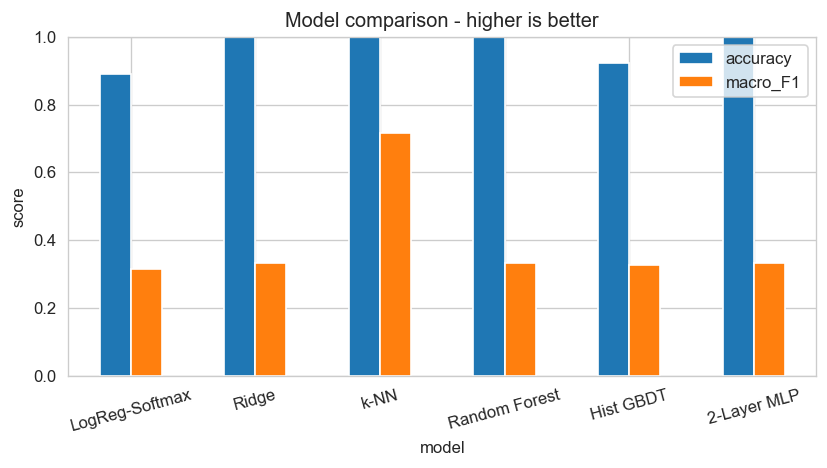

In [65]:
# Accuracy vs. macro-F1
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score")
plt.tight_layout()
plt.show()

#### 2.4 Confusion Matrix Comparison

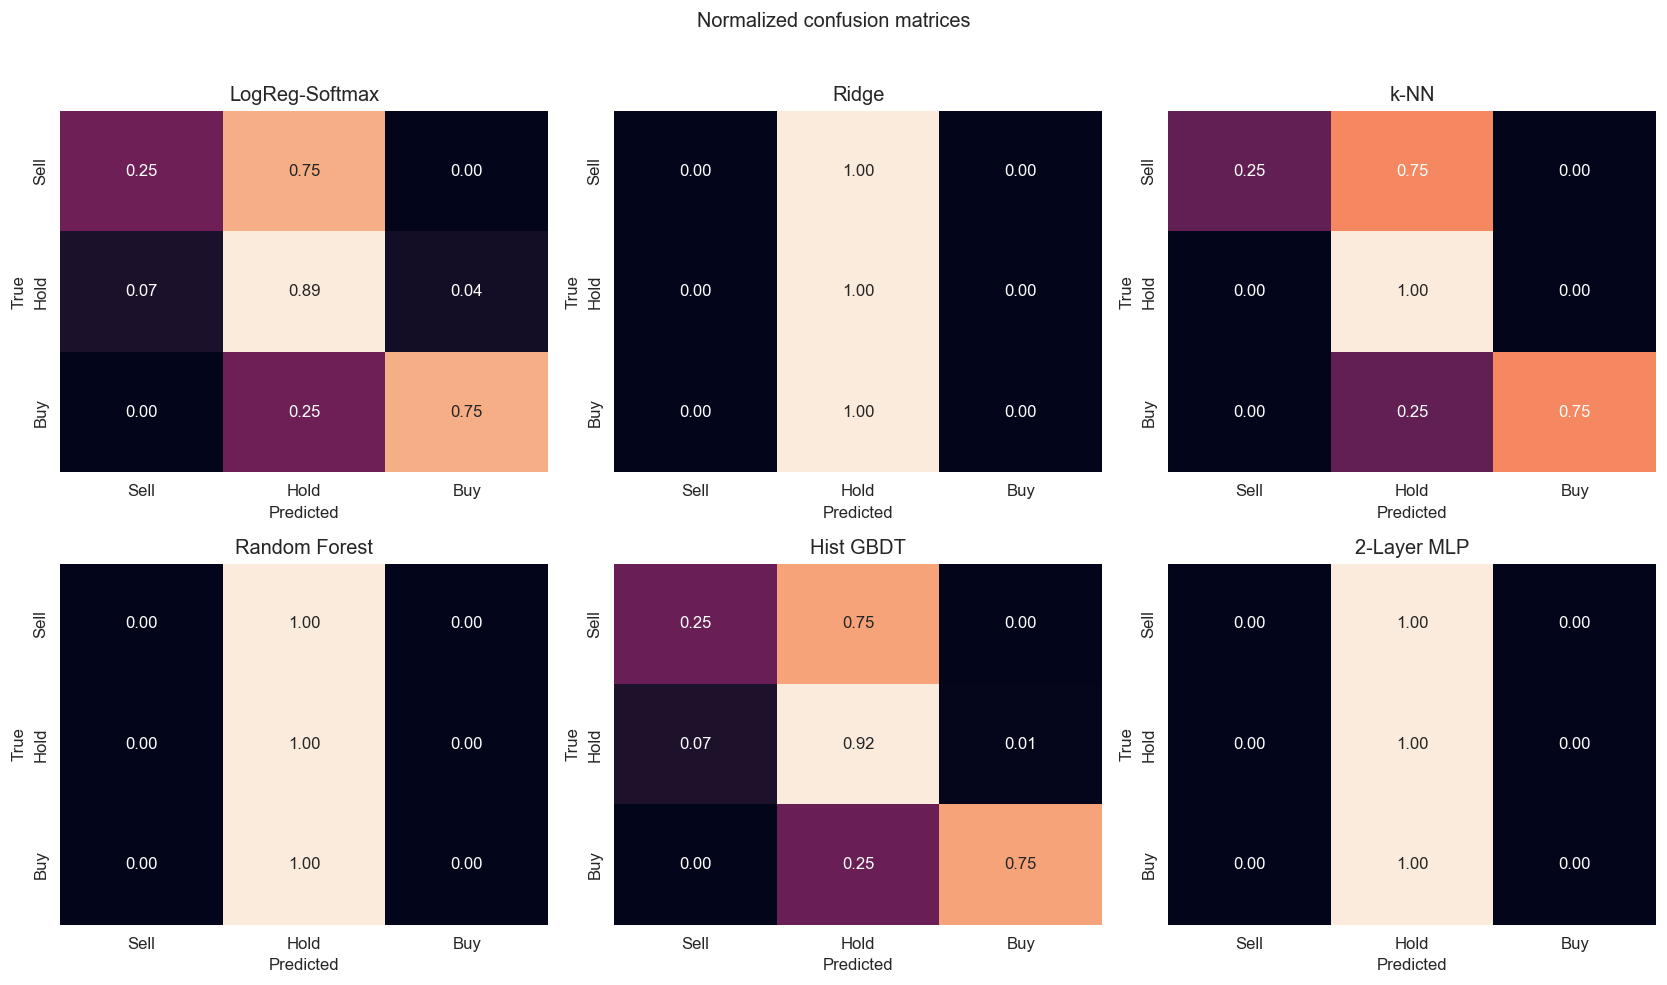

In [66]:
# 4-B Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout()
plt.show()

#### 2.5 Soft Voting Ensemble - Train and Evaluate

In [67]:
from sklearn.ensemble import VotingClassifier

estimators = []
for name, model in sk_models.items():
    if (name in ["LogReg-Softmax", "k-NN", "Hist GBDT"]):
        estimators.append((name, model))

voting_soft = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

voting_soft.fit(X_train_flat, y_train)

y_val_pred = voting_soft.predict(X_valid_flat)
print("Validation accuracy:", accuracy_score(y_valid, y_val_pred))
print("Validation F1 (weighted):", f1_score(y_valid, y_val_pred, average='weighted'))
cmap_vote_valid = confusion_matrix(y_valid, y_val_pred, labels=[-1, 0, 1], normalize='true')

y_test_pred = voting_soft.predict(X_test_flat)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1 (weighted):", f1_score(y_test, y_test_pred, average='weighted'))
cmap_vote_test = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1], normalize='true')

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=   8.0s
Validation accuracy: 0.9961234440776523
Validation F1 (weighted): 0.9978361864291561
Test accuracy: 0.9970321017565112
Test F1 (weighted): 0.9983716812476435


#### 2.5.1 Confusion matrix of voting classifier

In [68]:
cmaps_vote = {
    'valid': cmap_vote_valid,
    'test':  cmap_vote_test
}

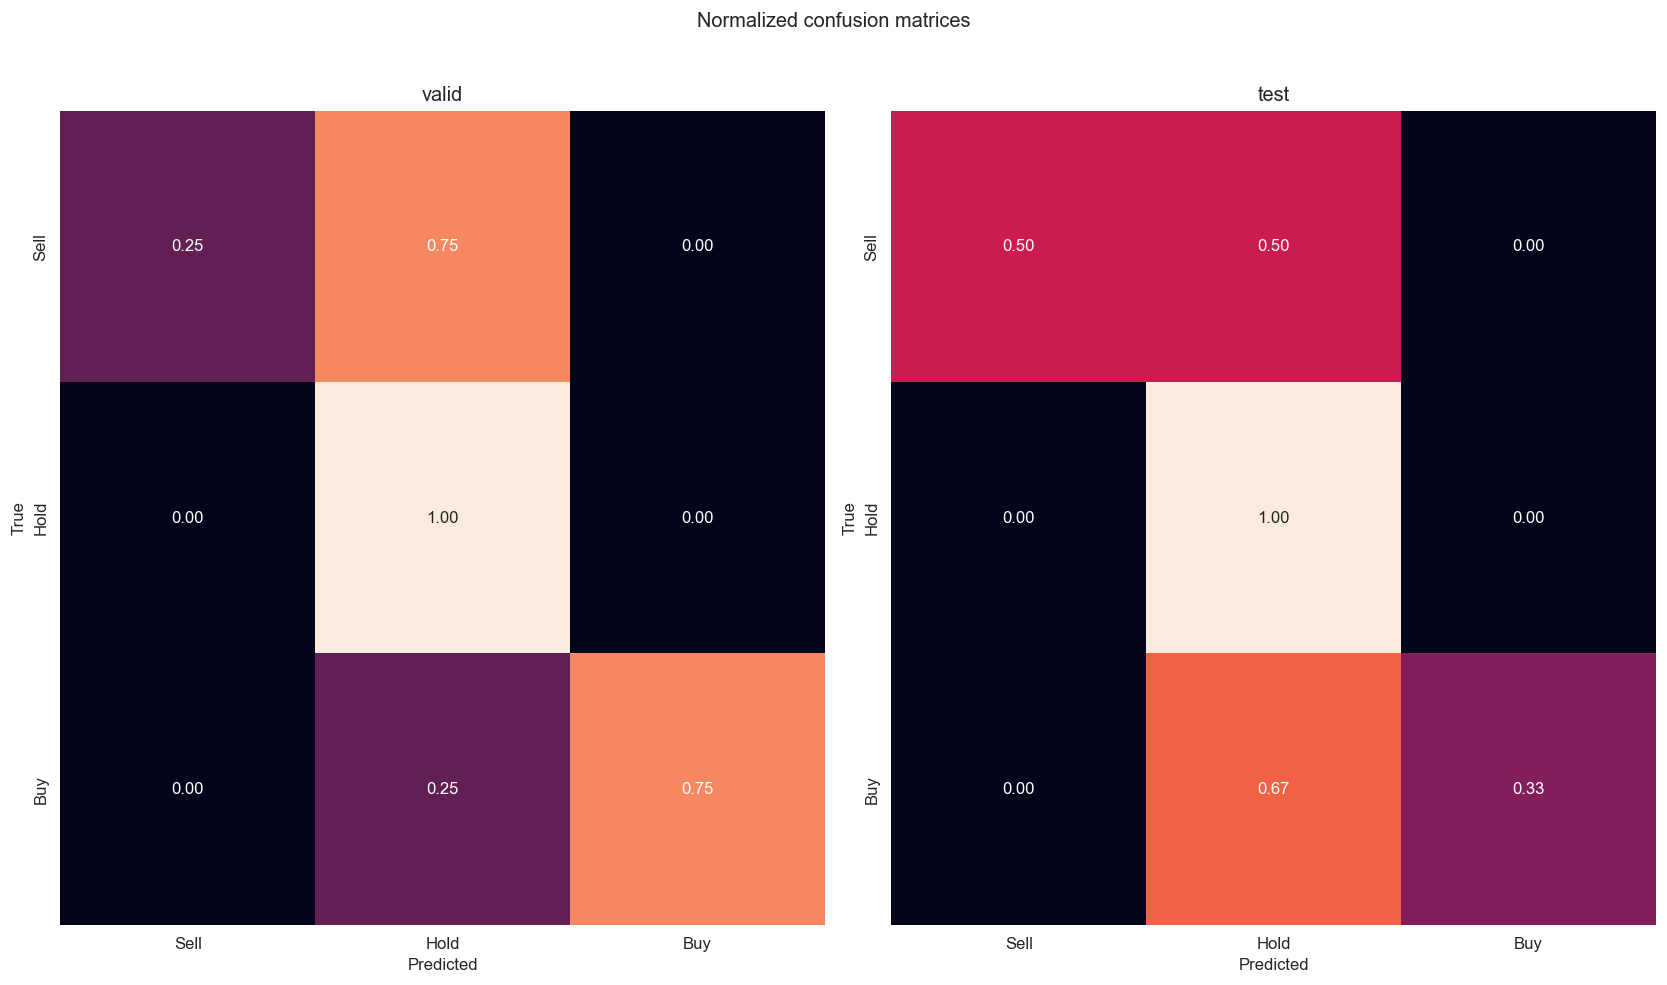

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
for ax, (name, cm) in zip(axes.ravel(), cmaps_vote.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout()
plt.show()

#### 2.6 Backtest – All Models vs. Buy & Hold Benchmark

/var/folders/p5/gv35v2wx4m7fndc0tw1bvpwm0000gn/T/ipykernel_30440/3677645622.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min
/var/folders/p5/gv35v2wx4m7fndc0tw1bvpwm0000gn/T/ipykernel_30440/3677645622.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min
/var/folders/p5/gv35v2wx4m7fndc0tw1bvpwm0000gn/T/ipykernel_30440/3677645622.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min


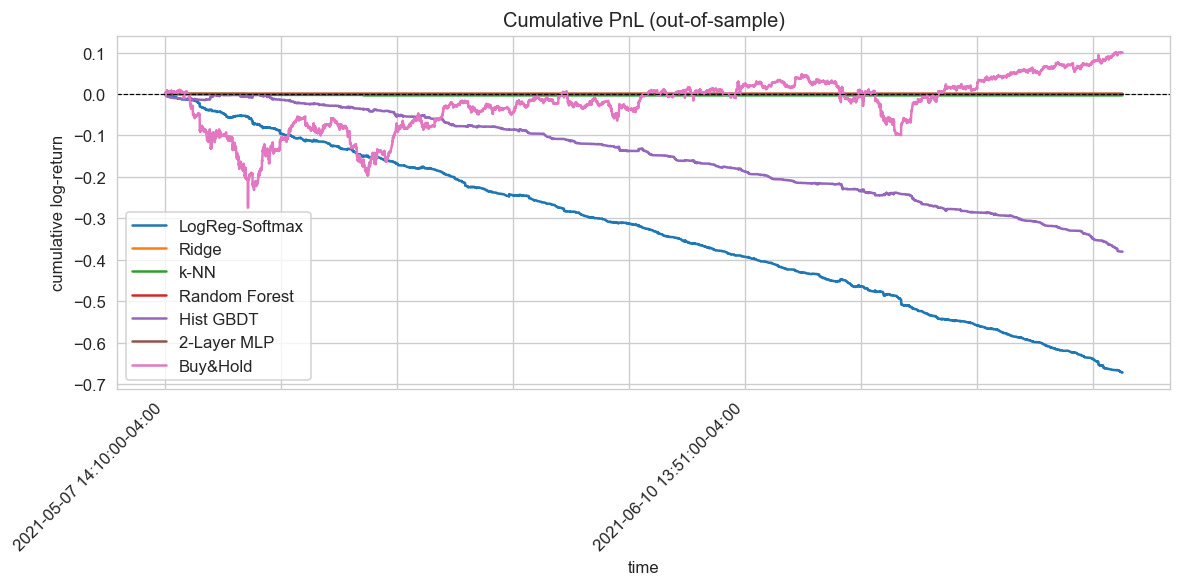

,Sharpe
LogReg-Softmax,-37.90
Ridge,NaN
k-NN,-2.54
Random Forest,NaN
Hist GBDT,-25.99
2-Layer MLP,NaN
Buy&Hold,1.21


In [70]:
# 5 Back-test – every model plus Buy & Hold
def backtest(pred, ret, fee_bp=1):
    gross = pred.shift(1) * ret           # enter next bar
    fee   = (pred.diff().abs() > 0).astype(int) * fee_bp/1e4
    return gross - fee

# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

pnl_curves, sharpes = {}, {}
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
from matplotlib.ticker import MaxNLocator

ax = pd.DataFrame(pnl_curves).plot(figsize=(10, 5))
ax.xaxis.set_major_locator(MaxNLocator(10))
plt.xticks(rotation=45, ha='right')
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.xlabel("time")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)
